<a href="https://colab.research.google.com/github/dannydrinkswater/AiLearning/blob/master/Herbs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#pip install -U git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
!unzip data.zip

In [0]:
# Read in the dataframe
df_train = pd.read_csv('./train.csv')
# convert id to category type
df_train = df_train.astype({"category_id":'str'})
# Shuffle 
df_train_shuffle = df_train.sample(frac=1).reset_index(drop=True)
# train test data split
train, test = train_test_split(df_train_shuffle,test_size=0.15)


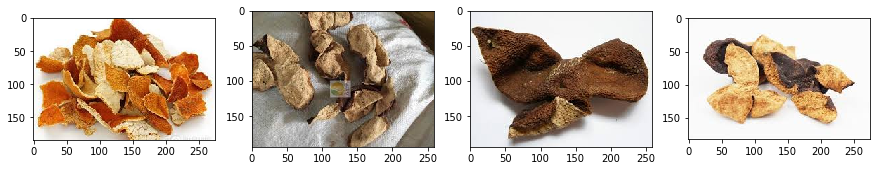

In [53]:
img_names = df_train_shuffle[df_train_shuffle['category_id']=="2"]['file_path'][:4]

# show the 
plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
  img = cv2.cv2.imread("%s" % img_name)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.subplot(1,4,i)
  plt.imshow(img)
  i+=1

plt.show()


In [0]:
nb_classes = len(df_train['category_id'].unique()) #9
batch_size = 32
img_size = 112
nb_epochs = 50

In [55]:
#%%time
train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.20,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(    
    dataframe=train,    
    directory=".",
    x_col="file_path",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 170 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=test,    
    directory=".",
    x_col="file_path",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 31 validated image filenames belonging to 9 classes.


In [0]:

from efficientnet.keras import EfficientNetB3
model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [0]:
model.trainable = False

In [59]:
x = model.output
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')


In [0]:
#%%time
history = model_final.fit_generator(generator=train_generator,  
                                    
                                    steps_per_epoch=5,
                                    
                                    validation_data=valid_generator, 
                                    
                                    validation_steps=2,
                                    
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=2)

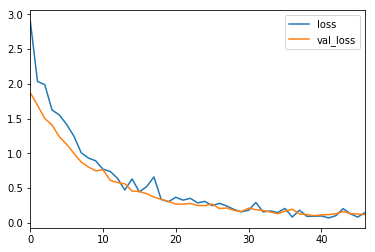

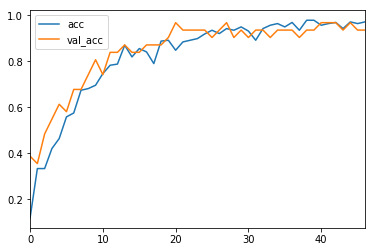

In [62]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [63]:
test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test,    
    
        directory = ".",    
        x_col="file_path",
        target_size = (img_size,img_size),
        batch_size = 1, # originally 1
        shuffle = False,
        class_mode = None
        )

Found 31 validated image filenames.


In [64]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 4.4 s, sys: 117 ms, total: 4.51 s
Wall time: 4.23 s


In [65]:
len(predict)

31

In [0]:
predicted_class_indices=np.argmax(predict,axis=1)
# convert cetegory index to category
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
Correct = test[test['category_id'] == predictions]
Wrong = test[test['category_id'] != predictions]

In [0]:
# create dictionary of category
name_dict={}
Category_name = ['化橘紅','陳皮','五加皮','肉桂','白朮','人參','西紅花','山銀花','金錢草']
for i,e in enumerate(Category_name):
  name_dict[i+1] = e

In [0]:
# Visualize images from each category that are classified correctly

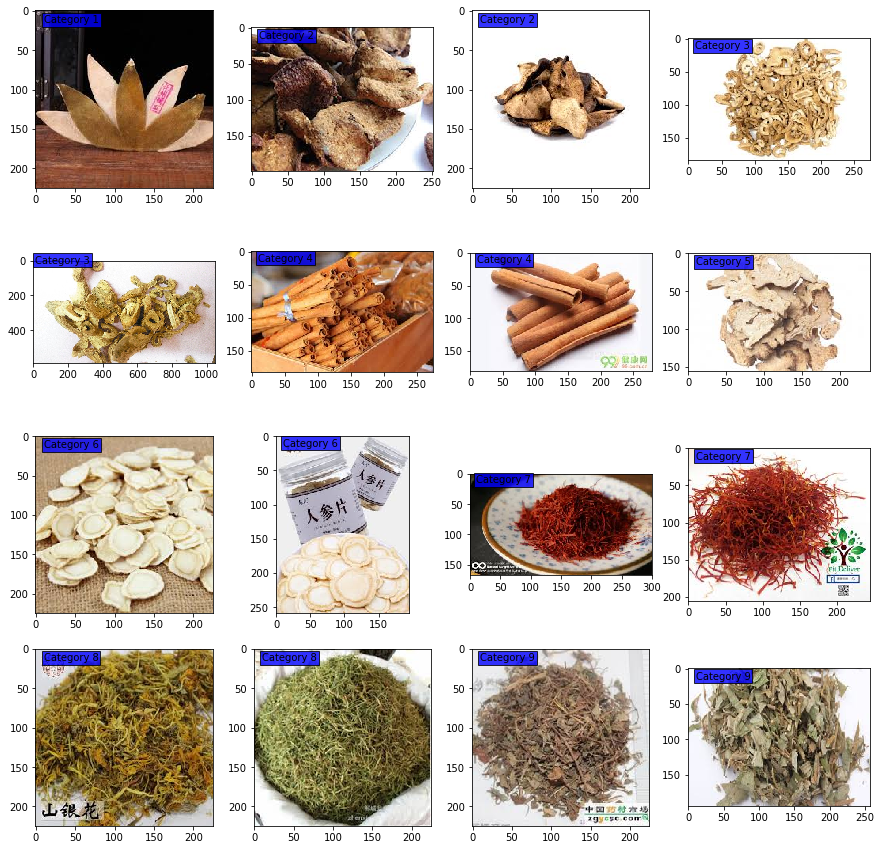

In [183]:
lll = Correct.sample(frac=1).groupby('category_id').head(2)
lll = lll.sort_values('category_id')

correct_img_names = lll['file_path']

# show the 
plt.figure(figsize=[15,15])
i=0

for img_name in correct_img_names:
  img = cv2.cv2.imread("%s" % img_name)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.subplot(4,4,(i+1))
  plt.imshow(img)
  title = ("Category %d" % (int(lll.iloc[i]['category_id'])))
  plt.text(10,15,title,bbox={'facecolor':'blue','alpha':0.8,'pad':2})
  #print(name_dict[int(Wrong.iloc[i]['category_id'])]) # correct
  #print(name_dict[false[i]]) # wrong
  #print(str(i+1)+ ". "+name_dict[int(Correct.iloc[i]['category_id'])]+ " classified as "+ name_dict[correct[i]])
  i+=1
  

plt.show()

In [81]:
print("Images that are classified wrongly")
Wrong

Images that are classified wrongly


,image_id,file_path,category_id
58,200,data/type9/image18.jpg,9
118,33,data/type2/image23.jpg,2


In [0]:
# Get the falsely predicted value
#false = [int(i) for e,i in enumerate(test['category_id']) if int(i) != int(predictions[e])]
false = [int(i) for e,i in enumerate(predictions) if int(i) != int(test.iloc[e]['category_id'])]
correct = [int(i) for e,i in enumerate(predictions) if int(i) == int(test.iloc[e]['category_id'])]

1. 金錢草 classified as 五加皮
2. 陳皮 classified as 金錢草


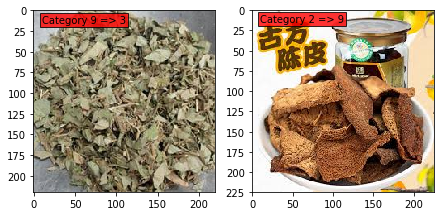

In [154]:
wrong_img_names = Wrong['file_path']

# show the 
plt.figure(figsize=[15,15])
i = 0
for img_name in wrong_img_names:
  img = cv2.cv2.imread("%s" % img_name)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.subplot(1,4,(i+1))
  plt.imshow(img)
  title = ("Category %d => %d" % (int(Wrong.iloc[i]['category_id']), false[i]))
  plt.text(10,15,title,bbox={'facecolor':'red','alpha':0.8,'pad':2})
  #print(name_dict[int(Wrong.iloc[i]['category_id'])]) # correct
  #print(name_dict[false[i]]) # wrong
  print(str(i+1)+ ". "+name_dict[int(Wrong.iloc[i]['category_id'])]+ " classified as "+ name_dict[false[i]])
  i+=1
  

plt.show()

In [0]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
model = load_model("vgg16_1.h5")

W0821 08:32:54.936964 139872223078272 deprecation.py:573] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
W0821 08:32:54.947429 139872223078272 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
